# Summary

**Needs revision based on new analysis**

**Action Points**

**1) Prioritize retention and risk mitigation in the "Online TA" segment**<br>
- Accounts for >50% of all successful bookings
- Has been more volatile in 2020 YTD versus equivalent dates 2019:
    - 32% rise in cancellations, therefore responsible for 106% of increase in cancellations
- Stabilising this segment is critical to maintaining overall booking volume and revenue consistency

**2) Reassess strategy for the "Offline TA/TO" segment**<br>
- Improvement in cancellations (-20%) in 2020 YTD versus equivalent dates 2019
- However, number of actual revenue-generating bookings dropped 36% - this is the biggest contributor to the 2020 YTD revenue shortfall, as this segment makes up about 23% of successful bookings (completed, or cancelled and non-refundable)
- Revival is a high priority
- Ideas examples:
    - Increased engagement with travel agents
    - Review of channel-specific pricing and package offerings

**3) Investigate root causes of longer lead times in general**<br>
- Whilst lead times for completed bookings have increased, so too have lead times for cancelled bookings, in 2020 YTD versus equivalent dates 2019.
- I.e. indicator of potential fragility: disturbs confidence in long-term revenue forecasting and management
- Possibility: previously introduced feature unintentially made reservations more tentative

**Needs revision based on new analysis**

**Fly-by:**

1) Revenue for 2018 (partial) far surpassed by equivalent-period 2019
- Main driver is number of bookings, not increased value of bookings
    - Especially in market segment **"Online TA"**, but also worth highlighting **"Offline TA/TO"** and **"Direct"**

2) YTD revenue 2020 almost matches that of equivalent-period 2019
- Sustainable: consistent month-by-month revenue growth in 2020
- Same three important market segments as mentioned above contributed proportionally to overall number of bookings as much in both 2019 and 2020
- However, number of revenue-generating bookings by secondary key segment "Offline TA/TO" decreased 36% in 2020 YTD vs 2019 YTD - _action point 2_

3) Encouraging: though number of bookings overall decreased, quality went up ("quality booking" := generated revenue)

4) Encouraging: longer average lead times in 2020 vs 2019, both overall and specifically in reference to those 3 major segments
- However,  lead time of cancelled bookings increased too, again for all 3 major segments - _action point 3_

5) (4) is especially noteworthy given the completion rate of bookings fell and actual number of cancellations rose in general, and most apparently in the key segment "Online TA" - _action point 1_

# Preamble

Summary of concerns and assumptions:
1) Assume SC meals (self-catered) have not had their price written in error, despite somehow costing more than full-board
2) Assume 'adr' (avg daily rate) is to be multiplied by nights stayed to find overall room rental revenue per booking, exclusive of meal costs
- See source: "Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights"
3) Assume meals are applied to every non-baby guest in the same booking, for every day (nights + 1) spent
4) Assume Null children --> 0 children
5) Assume no money made from cancelled bookings. Or rather, do admit possibility of reclaiming deposits, but assess revenues of strictly completed bookings first
6) Assume bookings of zero pax are unsuable data
7) Assume bookings with zero adr (avg daily rate) yet which are not cancelled are unusable data

# Prelim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Remove scientific notation in larger figures
pd.options.display.float_format = '{:.2f}'.format

## Load Data

In [3]:
# 2018 to 2020
# sheet_name = None --> all worksheets
df1 = pd.read_excel(r"D:\Code\Data Analysis\01 Hotel Bookings\hotel_revenue_historical_full-2.xlsx", sheet_name = None)

In [4]:
# 2015 to 2017
df2 = pd.read_csv(r"D:\Code\Data Analysis\01 Hotel Bookings\hotels.csv")

In [5]:
# Concat sheets within df1, having verified in source that columns match. Also from df2.
# ---> Consolidated fact table of bookings data 2015 to 2020
df_main = pd.concat([df1['2018'], df1['2019'], df1['2020'], df2])
pd.set_option("display.max.columns", 50)

In [6]:
df_main[df_main["is_canceled"] == 0].head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
7951,Resort Hotel,0,342,2018,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2018-07-01 00:00:00
7952,Resort Hotel,0,737,2018,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2018-07-01 00:00:00
7953,Resort Hotel,0,7,2018,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2018-07-02 00:00:00
7954,Resort Hotel,0,13,2018,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,NaN,0,Transient,75.00,0,0,Check-Out,2018-07-02 00:00:00
7955,Resort Hotel,0,14,2018,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,NaN,0,Transient,98.00,0,1,Check-Out,2018-07-03 00:00:00
7956,Resort Hotel,0,14,2018,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,NaN,0,Transient,98.00,0,1,Check-Out,2018-07-03 00:00:00
7957,Resort Hotel,0,0,2018,July,27,1,0,2,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.00,0,0,Check-Out,2018-07-03 00:00:00
7958,Resort Hotel,0,9,2018,July,27,1,0,2,2,0.00,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.00,NaN,0,Transient,103.00,0,1,Check-Out,2018-07-03 00:00:00
7959,Resort Hotel,0,35,2018,July,27,1,0,4,2,0.00,0,HB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.00,NaN,0,Transient,145.00,0,0,Check-Out,2018-07-05 00:00:00
7960,Resort Hotel,0,68,2018,July,27,1,0,4,2,0.00,0,BB,USA,Online TA,TA/TO,0,0,0,D,E,0,No Deposit,240.00,NaN,0,Transient,97.00,0,3,Check-Out,2018-07-05 00:00:00


In [7]:
# Dimension table 1
# Typically would assume SC (self-catered) --> cheaper
# Seems not the case this time. Raise concern of error, but go along with it (do not drop SC or any such action)

df_meal_cost = df1['meal_cost']
df_meal_cost

,Cost,meal
0,0.00,Undefined
1,12.99,BB
2,17.99,HB
3,21.99,FB
4,35.00,SC


In [8]:
# Dimension table 2
# Note discounted price would be price * (1 - discount)

df_market_segment = df1['market_segment']
df_market_segment

,Discount,market_segment
0,0.00,Undefined
1,0.10,Direct
2,0.10,Groups
3,0.15,Corporate
4,0.20,Aviation
5,0.30,Offline TA/TO
6,0.30,Online TA
7,1.00,Complementary


# Clean and Structure Data

## Dupes, Nulls, Anomalies

In [9]:
# Any dupes?
# 73185
len(df_main[df_main.duplicated()])

73185

In [10]:
# Can't find justification for why these dupes need to be kept, so drop them
df_main.drop_duplicates(inplace=True)
len(df_main[df_main.duplicated()])

0

In [11]:
df_main.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                              12
babies                                 0
meal                                   0
country                             1013
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              26732
company         

Note: null categorical data like 'agent' and 'company' explained in data dictionary as meaning N/A, not missing in value

In [12]:
# Assumption: null children = 0. Need non-null to convert to int (from float), in next cell
df_main["children"] = df_main["children"].fillna(value = 0)

In [13]:
# Convert datatypes:
    # children to integer from float
    # reservation_status_date to datetime from object
df_main["children"] = df_main["children"].astype(np.int64)
df_main["reservation_status_date"] = pd.to_datetime(df_main["reservation_status_date"])#.dt.date
df_main.dtypes

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

## Feature Engineering, Further Cleaning

In [14]:
# Convert month from English name ('July') to number (7)
df_main["arrival_date_month"] = pd.to_datetime(df_main["arrival_date_month"], format = "%B").dt.month

# Combine separate arrival date columns into singular date column
df_main["arrival_date"] = pd.to_datetime({
    'year': df_main['arrival_date_year'],
    'month': df_main['arrival_date_month'],
    'day': df_main['arrival_date_day_of_month']
})

In [15]:
df_main[["arrival_date", "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"]].head(15)

,arrival_date,arrival_date_year,arrival_date_month,arrival_date_day_of_month
0,2018-07-01,2018,7,1
1,2018-07-01,2018,7,1
2,2018-07-01,2018,7,1
3,2018-07-01,2018,7,1
4,2018-07-01,2018,7,1
5,2018-07-02,2018,7,2
6,2018-07-02,2018,7,2
7,2018-07-02,2018,7,2
8,2018-07-02,2018,7,2
9,2018-07-02,2018,7,2


In [16]:
# Don't drop - easier filtering if retained
#df_main = df_main.drop(labels = ["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis = 1)

In [17]:
df_main["pax"] = df_main["adults"] + df_main["children"] + df_main["babies"]

In [18]:
len(df_main[df_main["pax"] == 0])

361

In [19]:
# Absent deeper knowledge on booking system, assume 0 pax bookings are in error / not usable
df_main = df_main[df_main["pax"] != 0].copy()

In [20]:
# adr := sum of all lodging transactions divided by total number of staying nights
# So sum of all lodging transactions per booking (row) is adr * nights

df_main["nights"] = df_main["stays_in_week_nights"] + df_main["stays_in_weekend_nights"]
df_main[["nights", "stays_in_week_nights", "stays_in_weekend_nights"]].head(10)

,nights,stays_in_week_nights,stays_in_weekend_nights
0,3,3,0
1,3,3,0
2,4,4,0
3,7,5,2
4,10,8,2
5,4,3,1
6,4,3,1
7,4,3,1
8,5,3,2
9,7,5,2


In [21]:
# 3,634 entries are not cancelled yet have adr (avg daily rate) of 0.
# adr is "calculated by dividing the sum of all lodging transactions by the total number of staying nights"
df_main.groupby([(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)]).size()

False    184422
True       3369
dtype: int64

In [22]:
# There are examples below of adr = 0, canceled = 0, and nights != 0
# Even if strictly nights = 0 for these conditions, that wouldn't easily explain anything, but might have been a hint into reasoning

# df_main[["nights", "stays_in_weekend_nights", "stays_in_week_nights"]][(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].sort_values(by = df_main["nights"], ascending=False)

df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)][["nights", "stays_in_weekend_nights", "stays_in_week_nights"]].sort_values(by="nights", ascending=False)

,nights,stays_in_weekend_nights,stays_in_week_nights
34715,48,14,34
54704,48,14,34
1655,46,13,33
8989,46,13,33
65696,46,13,33
...,...,...,...
115483,0,0,0
117701,0,0,0
118029,0,0,0
18836,0,0,0


In [23]:
# Examples below show that cases of adr = 0 & is_canceled = 0 do not congregate around one particular dimension value,
# which would hint that the result is systematic --> stronger evidence that this is erroneous / not by design
df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("market_segment").size().sort_values(ascending = False)
# df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("distribution_channel").size().sort_values(ascending = False)
# df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("customer_type").size().sort_values(ascending = False)

market_segment
Complementary    1228
Online TA         661
Offline TA/TO     487
Groups            451
Direct            404
Corporate         132
Aviation            6
dtype: int64

In [24]:
# Note too that "Complementary" market segment discount of 100% is applied in post, as seen by max 'adr' for this segment being > 0
df_main.groupby(df_main["market_segment"] == "Complementary")["adr"].max()

market_segment
False   5400.00
True     170.00
Name: adr, dtype: float64

In [25]:

# Absent more detailed knowledge of subject matter, assume the examples found are unusable
# Even if these are explained by e.g. vouchers and perks, there is no alternate column to demonstrate this anyway
df_main = df_main[~((df_main["adr"] == 0) & (df_main["is_canceled"] == 0))].copy()
# After slicing, e.g. as above, Pandas does not necessarily create a totally new df_main, rather just a shallow copy, or even just a view
# So later when e.g. adding new columns, Pandas not sure if applying to original or view, and changes may or may not exist
# Therefore make a deep copy

In [26]:
# reservation_status := ['canceled', 'check out', 'no show']
# reservation_status_date := "Date at which the last status was set [...] understand when was the booking canceled or when did the customer checked-out of the hotel"
df_main.groupby("arrival_date_year")["reservation_status_date"].agg(['min', 'max'])
# (Later standardise the format of column)

,min,max
arrival_date_year,,
2015,2014-10-17,2016-01-14
2016,2015-06-26,2017-01-14
2017,2015-10-21,2017-09-14
2018,2014-10-17,2019-01-14
2019,2014-10-17,2020-01-14
2020,2018-10-21,2020-09-14


In [27]:
# Some min dates look suspicious
# Technically, would be possible in the case of cancellations for the reserve_status_date to preceded arrival_date

# First see if any cases where reserve_status_date < arrival_date but corresponding status was not cancellation
# Where 'is_canceled' = 1 yet reservation_status is not 'Canceled', we prioritise the reservation_status, to align with documentation

# df_main[(df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled')]
df_main[["is_canceled", "reservation_status", "reservation_status_date", "arrival_date"]][(df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled')]

,is_canceled,reservation_status,reservation_status_date,arrival_date
56104,1,No-Show,2019-03-28,2019-07-17
66832,0,Check-Out,2019-01-05,2019-12-08
66852,0,Check-Out,2019-01-05,2019-12-17
66889,0,Check-Out,2019-01-02,2019-12-23
66905,0,Check-Out,2019-01-01,2019-12-24
...,...,...,...,...
79259,1,Check-Out,2019-01-06,2019-03-01
79260,1,Check-Out,2018-11-20,2019-03-02
79261,1,Check-Out,2018-11-20,2019-03-02
79263,1,Check-Out,2019-01-27,2019-03-02


In [28]:
# 328 rows cannot be explained - delete
# Exclude the 328 problematic rows
df_main = df_main[~((df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled'))].copy()

In [29]:
# lead_time := number of days [...]] between the entering date of the booking into the PMS and the arrival date
# PMS := Property Management System

# Wouldn't make sense for reservation_status_date to precede the booking_date in any scenario (cancellation, no show, check out)
# Derive booking_date from datediff(arrival - lead time) then compare:


df_main["booking_date"] = df_main["arrival_date"] - pd.to_timedelta(df_main["lead_time"], unit='days')
df_main[["is_canceled", "reservation_status", "reservation_status_date", "arrival_date", "lead_time", "booking_date"]][df_main["booking_date"] > df_main["reservation_status_date"]]

,is_canceled,reservation_status,reservation_status_date,arrival_date,lead_time,booking_date
566,1,Canceled,2014-11-18,2018-09-03,297,2017-11-10
4215,1,Canceled,2014-10-17,2018-07-09,265,2017-10-17
4216,1,Canceled,2014-10-17,2018-07-02,258,2017-10-17
4236,1,Canceled,2014-10-17,2018-07-09,265,2017-10-17
4255,1,Canceled,2014-10-17,2018-07-16,272,2017-10-17
...,...,...,...,...,...,...
15287,1,Canceled,2020-01-09,2020-08-25,228,2020-01-10
15325,1,Canceled,2020-02-12,2020-08-26,195,2020-02-13
15346,1,Canceled,2020-02-19,2020-08-27,189,2020-02-20
15413,1,Canceled,2020-02-04,2020-08-30,207,2020-02-05


In [30]:
# Can't explain above 688 rows where booking_date > reservation_status_date ("latest" status), so delete:

df_main = df_main[~(df_main["booking_date"] > df_main["reservation_status_date"])].copy()

In [31]:
# reservation_status == 'Canceled' := customer cancelled
# is_canceled == 1 := cancelled on booking system ... presumably by hotel operator
# So below instances of reservation_status == 'Check-Out' but is_canceled == 1 don't make sense?

df_main[(df_main["is_canceled"] == 1)].groupby("reservation_status").size()

reservation_status
Canceled     47852
Check-Out        2
No-Show       2179
dtype: int64

In [32]:
# Drop 2 instances of is_canceled == 1 and reservation_status == 'Check-Out'
df_main = df_main[~((df_main["is_canceled"] == 1) & (df_main["reservation_status"] == 'Check-Out'))].copy()

In [33]:
df_main[(df_main["is_canceled"] == 0)].groupby("reservation_status").size()

reservation_status
Check-Out    133373
dtype: int64

### Seasonal Analysis Set-up

In [34]:
df_main.groupby("arrival_date_year")["arrival_date"].agg(['min', 'max']).reset_index()

,arrival_date_year,min,max
0,2015,2015-07-01,2015-12-31
1,2016,2016-01-01,2016-12-31
2,2017,2017-01-01,2017-08-31
3,2018,2018-07-01,2018-12-31
4,2019,2019-01-01,2019-12-31
5,2020,2020-01-01,2020-08-31


https://www.practiceportuguese.com/learning-notes/seasons-of-the-year/
- Spring: 20 Mar < 21 June
- Summer: 21 June < 23 Sept
- Autumn: 23 Sept < 21 Dec
- Winter: 21 Dec < 20 Mar

In [35]:
# Though we can extract mm-dd from yyyy-mm-dd as below,
# this outputs as object dtype, which can't easily be compared to date parameters.
# df_main["arrival_date"].dt.strftime('%m-%d')
# So instead, use day of year:

df_main['day_of_year'] = df_main["arrival_date"].dt.dayofyear

def get_season(day_of_year):
    if 80 <= day_of_year <= 171:  # Mar 20 - Jun 20
        return 'spring'
    elif 172 <= day_of_year <= 266:  # Jun 21 - Sep 22
        return 'summer'
    elif 267 <= day_of_year <= 355:  # Sep 23 - Dec 20
        return 'autumn'
    else:
        return 'winter'

df_main['season'] = df_main['day_of_year'].apply(get_season)
# dataframe.apply(function) := apply a function along an axis of a dataframe

2015, 2018: partial summer, full autumn, partial winter <br>
2016, 2019: all seasons <br>
2017, 2020: partial winter, full spring, partial summer <br>

If we are to investigate cancellation *rate* and adr (*"rate"*), it is fine to include the partial seasons. <br>
I.e. we are not aggregating a sum, which would in that case be distorted by different coverage

In [36]:
# Cutom ordering for seasons
season_order = ["spring", "summer", "autumn", "winter"]
df_main['season'] = pd.Categorical(df_main['season'], categories=season_order, ordered=True)

# EDA - Univariate Analysis

Look at the shape of columns to see if any notable data issues or points to note, etc.

In [37]:
df_main.groupby(df_main["arrival_date_year"]).size()

arrival_date_year
2015    12863
2016    41599
2017    31293
2018    12851
2019    54169
2020    30629
dtype: int64

In [38]:
# Sizes conditional on not cancelled
df_main[df_main["is_canceled"] == 0].groupby(["arrival_date_year"]).size()

arrival_date_year
2015    10160
2016    30400
2017    21187
2018    10160
2019    40279
2020    21187
dtype: int64

In [40]:
# To be sure, see min and max dates per year
df_main.groupby("arrival_date_year")["arrival_date"].agg(['min', 'max']).reset_index()

,arrival_date_year,min,max
0,2015,2015-07-01,2015-12-31
1,2016,2016-01-01,2016-12-31
2,2017,2017-01-01,2017-08-31
3,2018,2018-07-01,2018-12-31
4,2019,2019-01-01,2019-12-31
5,2020,2020-01-01,2020-08-31


In [41]:
# Would make sense to normalise to a per-month basis if comparing YoY (and in fact, YTD i.e. equivalent months)
df_months_per_year = df_main.groupby("arrival_date_year", as_index = False)["arrival_date_month"].nunique().rename(columns = {"arrival_date_month" : "count_months_covered"})
df_months_per_year

,arrival_date_year,count_months_covered
0,2015,6
1,2016,12
2,2017,8
3,2018,6
4,2019,12
5,2020,8


In [42]:
# Bookings per month by year:
df_size_by_year = df_main.groupby(df_main["arrival_date_year"], as_index = False).size()
df_size_by_year = df_size_by_year.merge(df_months_per_year, on = "arrival_date_year")
df_size_by_year["size_norm"] = df_size_by_year["size"] / df_size_by_year["count_months_covered"]
df_size_by_year

,arrival_date_year,size,count_months_covered,size_norm
0,2015,12863,6,2143.83
1,2016,41599,12,3466.58
2,2017,31293,8,3911.62
3,2018,12851,6,2141.83
4,2019,54169,12,4514.08
5,2020,30629,8,3828.62


In [43]:
# # Seems 2015 vs 2018; 2017 vs 2020 are just copies?
# df_main.groupby("arrival_date_year")["pax"].sum()
# df_main.groupby("arrival_date_year")["nights"].sum()

In [44]:
# # Below indicates the data across years are not copies
# cols_to_compare = [col for col in df_main.columns if col not in ["arrival_date_year", "arrival_date", "reservation_status", "arrival_date_month", "arrival_date_day_of_month", "arrival_date_week_number"]]

# df_2015 = df_main[df_main["arrival_date_year"] == 2015].sort_values(cols_to_compare).reset_index(drop=True)
# df_2018 = df_main[df_main["arrival_date_year"] == 2018].sort_values(cols_to_compare).reset_index(drop=True)

# print((df_2015[cols_to_compare]).equals(df_2018[cols_to_compare]))
# # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.equals.html

In [45]:
# Size split by hotel type
df_main.groupby(df_main["hotel"]).size()

hotel
City Hotel      110451
Resort Hotel     72953
dtype: int64

In [46]:
# Size split by cancellation
df_main.groupby(df_main["is_canceled"]).size()

is_canceled
0    133373
1     50031
dtype: int64

In [47]:
# Size split by deposit_type
df_main.groupby(df_main["deposit_type"]).size()

deposit_type
No Deposit    180948
Non Refund      2241
Refundable       215
dtype: int64

In [48]:
# Distribution by nights
df_main.aggregate({"nights" : ['min', 'max', 'mean', 'median', 'std']})

,nights
min,0.00
max,69.00
mean,3.68
median,3.00
std,2.74


In [49]:
Q1_nights = df_main['nights'].quantile(0.25)
Q3_nights = df_main['nights'].quantile(0.75)

IQR_nights = Q3_nights - Q1_nights

print(f"Q1: {Q1_nights}, Q3: {Q3_nights}, IQR: {IQR_nights}")

Q1: 2.0, Q3: 5.0, IQR: 3.0


In [50]:
# Whilst 69 nights is many std dev away from mean, it does seem plausible, just from an intuitive sense of hotel booking possibilities
# Other values at the tail support idea that this is not completely out of the blue:
df_main[df_main["nights"] > 21].groupby("nights").size()

nights
22    29
23    12
24    12
25    28
26    12
27     9
28    72
29    25
30    24
33     5
34     2
35    10
38     2
42     8
45     2
56     4
60     3
69     2
dtype: int64

Consider categorising nights stayed into custom short/medium/long stays

In [51]:
# Nights := number of nights guest did stay or booked to stay
# Note too that any instances of nights == 0 necessarily has is_canceled = 1
# Which may or may not be of business importance - best to check.
# Realistically, room probably can be booked for zero nights, so leave as is
# len(df_main.loc[(df_main["nights"] == 0) & (df_main["is_canceled"] == 0)])

len(df_main[((df_main["nights"] == 0) & (df_main["is_canceled"] == 0))])

0

In [52]:
# Distribution by pax
df_main.aggregate({"pax" : ['min', 'max', 'mean', 'median', 'std']})

,pax
min,1.00
max,55.00
mean,2.03
median,2.00
std,0.82


In [53]:
Q1_pax = df_main['pax'].quantile(0.25)
Q3_pax = df_main['pax'].quantile(0.75)

IQR_pax = Q3_pax - Q1_pax

print(f"Q1: {Q1_pax}, Q3: {Q3_pax}, IQR: {IQR_pax}")

Q1: 2.0, Q3: 2.0, IQR: 0.0


In [54]:
# 55 pax is mny std dev away from mean, but as with 'nights', is probably a situation where statistical norms take second place to business sense,
# and it does seem reasonable for a booking of 55 pax to emerge, especially from a 'Group' or 'Corporate' category.
# Would intend to check on this for a real stakeholder. For this project, leave as is
# Other values at the tail support idea that this is not completely out of the blue:
df_main.groupby("pax").size()

pax
1      33397
2     120813
3      20822
4       8040
5        282
6          3
10         6
12         5
20         6
26        15
27         6
40         3
50         3
55         3
dtype: int64

As with # nights, consider categorising pax in groups

In [55]:
# Other sizing and distributions
# df_main.groupby("distribution_channel")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby("customer_type")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby("market_segment")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby(["reserved_room_type"]).size()
# df_main.groupby(["assigned_room_type"]).size()

In [56]:
# Distribution by lead time
df_main.aggregate({"lead_time" : ['min', 'max', 'mean', 'median', 'std']})

,lead_time
min,0.00
max,709.00
mean,78.92
median,48.00
std,85.20


In [57]:
Q1_lead_time = df_main['lead_time'].quantile(0.25)
Q3_lead_time = df_main['lead_time'].quantile(0.75)

IQR_lead_time = Q3_lead_time - Q1_lead_time

print(f"Q1: {Q1_lead_time}, Q3: {Q3_lead_time}, IQR: {IQR_lead_time}")

Q1: 11.0, Q3: 123.0, IQR: 112.0


In [58]:
# Booking 709d in advance is quite far out, but still believable, and below suggests it is part of a legitimate long tail
df_main[df_main["lead_time"] >= 123].groupby(["lead_time"]).size()

lead_time
123    440
124    455
125    422
126    395
127    402
      ... 
615      4
622      4
626      2
629      4
709      2
Length: 355, dtype: int64

Likewise consider making categories to batch lead_times into manageable groups

TA = Travel Agents
TO = Tour Operators

In [59]:
df_main.groupby("market_segment").size()

market_segment
Aviation            446
Complementary       306
Corporate          9104
Direct            25207
Groups            10625
Offline TA/TO     30159
Online TA        107551
Undefined             6
dtype: int64

In [60]:
df_main.groupby(["distribution_channel"]).size()

distribution_channel
Corporate     10749
Direct        26766
GDS             355
TA/TO        145519
Undefined        15
dtype: int64

Agent := ID of travel angency making booking

In [61]:
# Note below examples of agent not null but other relevant columns not strictly being 'TA', which is what we would expect, given the terminology at hand
# ... not strictly intuitive what the business definitions here are - worth clarifying with SME. For now just leave as is (don't drop, etc.)
agent_not_null = df_main[df_main['agent'].notna()]
agent_not_null = agent_not_null[['distribution_channel', 'market_segment']].drop_duplicates().copy()
agent_not_null

,distribution_channel,market_segment
0,TA/TO,Online TA
1,TA/TO,Offline TA/TO
18,Direct,Direct
67,TA/TO,Direct
82,Direct,Groups
360,Corporate,Corporate
562,TA/TO,Groups
954,Corporate,Groups
2354,Undefined,Direct
2445,Undefined,Online TA


In [62]:
# There are 333 distinct agents
len(df_main["agent"].unique())

333

'Company' := ID of the company/entity that made the booking or responsible for paying the booking

In [63]:
# There are 346 distinct companies
len(df_main["company"].unique())

346

**Univariate Analysis Takeaways**

- There is expansive data / large ranges in interesting possible variables like pax, lead-time, market-segment, distribution channel, nights, cancellations
- Such that for numerical ones like nights and pax, may be adviseable to create categories for classifying batches
- As is probably expected, nights and pax have a tendency towards lower numbers (smaller bookings for fewer nights), but this does not mean an absence of larger, longer bookings

# Cancellations Analysis

- 'is_canceled' refers to hotel booking system
- 'reservation_status' refers to customer decision (canceled or no-show or checked-out already)
- Here, we will look into reservation_status == 'Canceled' --> has the customer announced a conscious decision to cancel?


https://experience-crm.fr/en/where-do-cancellations-come-from/#:~:text=Average%20cancellation%20rates&text=The%20average%20percentage%20of%20canceled,no%20room%20for%20nasty%20surprises.
- Published 2016-11-14
- Modified 2023-08-02
- The average percentage of canceled reservations, across **all sources**, is currently **24%**.
-  If you look only at **online** bookings, this rate increases to **38%**,
- and therefore all **“offline”** reservations [...] 10%.

https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average
- Published 2019-04-24; Modified 01/14/2025
- **online** distribution performance of more than 200 different channels for 680 properties in Europe between 2014 and 2018
- With the exception of 2018, every single channel has observed a marked increase in cancellation rate YoY.
- And, even in 2018, the number was 7.1 points above 2014.
- With a global average of almost **40%** cancellation rate [...].
- 2014 to 2018: 32.5%, 34.8%, 39.6%, 41.3%, 39.6%
- Across **online** sources: Booking Group, Expedia Group, Hotelbeds Group, HRS Group, Other OTAs, Other Wholesalers, Website Direct

https://www.phocuswire.com/One-in-five-hotel-bookings-on-the-web-are-cancelled
- Published 31 Dec, 2015
- Some **19%** of hotels that are booked **online** are cancelled before the guest arrives at the hotel, according to data provided by 

https://www.d-edge.com/avoid-guests-ghosting/
- According to our 2024 Hotel Distribution Report, hotel booking cancellation rates range from 18% to 42%.
- In Europe, the cancellation rate for direct bookings was 18% in 2023 [...] these rates increased for OTA bookings: in Europe, Expedia had a cancellation rate of 31%, while Booking Holdings reached 42%. 


In [ ]:

len_canc = len(df_main[df_main["reservation_status"] == 'Canceled'])
len_total = len(df_main)
pc_canc = round((len_canc / len_total), 3) * 100

print(f"bookings cancelled: {len_canc},\nbookings total: {len_total},\npc_cancelled: {pc_canc}")

bookings cancelled: 47852,
bookings total: 183404,
pc_cancelled: 26.1


26.1% of bookings end up being canceled by the customer<br>
With this limited perspective (considering all channels indiscriminately, rudimentary market research), we might say 26.1% is acceptable / comaprable to market standards, but not outstanding.<br>
Although we might better treat the '40%' value as an outlier, and thus deem our cancellation rate over the benchmark, and in need of special attention.
(18% < 24% < 26.1% < ~40%).<br>
In any case, whilst there would be greater thrust to investigate the issue if indeed deemed below standard,<br>
it is always worth gaining insight into cancellation rates, as any amount of optimisation in this regard is worthwhile.

## Time-based Variables vs Cancellation Rate

In [ ]:
df_yyyy_cancellations = df_main.groupby("arrival_date_year").size().reset_index().rename(columns = {0 : "bookings"})

df_yyyy_cancellations2 = df_main[["arrival_date_year", "is_canceled"]].groupby("arrival_date_year")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_yyyy_cancellations = df_yyyy_cancellations.merge(df_yyyy_cancellations2, on = "arrival_date_year")

df_yyyy_cancellations["cancellation_rate"] = df_yyyy_cancellations["cancellations"] / df_yyyy_cancellations["bookings"]
df_yyyy_cancellations = df_yyyy_cancellations[["arrival_date_year", "cancellation_rate", "bookings", "cancellations"]]
df_yyyy_cancellations

,arrival_date_year,cancellation_rate,bookings,cancellations
0,2015,0.21,12863,2703
1,2016,0.27,41599,11199
2,2017,0.32,31293,10106
3,2018,0.21,12851,2691
4,2019,0.26,54169,13890
5,2020,0.31,30629,9442


Relatively lower cancellation rate in 2015, 2018 / higher in 2017, 2020.<br>
Good to get to the bottom of that, as an 11 p.p. swing from lowest to highest rate is fairly large and probably has revenue management implications<br>
The above is approx 50% relative increase, so fairly substantial.<br><br>
Must remember though, that certain years lack data from certain seasons, so this is not necessarily a year-effect, but a seasonal one.<br>
Reminder:
    2015, 2018: partial summer, full autumn, partial winter; 2016, 2019: all seasons; 2017, 2020: partial winter, full spring, partial summer

In [ ]:
df_seasonal_cancellations = df_main.groupby("season").size().reset_index().rename(columns = {0 : "bookings"})

df_seasonal_cancellations2 = df_main[["season", "is_canceled"]].groupby("season")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_seasonal_cancellations = df_seasonal_cancellations.merge(df_seasonal_cancellations2, on = "season")

df_seasonal_cancellations["cancellation_rate"] = df_seasonal_cancellations["cancellations"] / df_seasonal_cancellations["bookings"]
df_seasonal_cancellations_basic = df_seasonal_cancellations[["season", "cancellation_rate", "bookings", "cancellations"]]
df_seasonal_cancellations_basic

C:\Users\danie\AppData\Local\Temp\ipykernel_3460\1579918832.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations = df_main.groupby("season").size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_3460\1579918832.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations2 = df_main[["season", "is_canceled"]].groupby("season")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


,season,cancellation_rate,bookings,cancellations
0,spring,0.29,47128,13740
1,summer,0.30,63464,19168
2,autumn,0.23,37773,8589
3,winter,0.24,35039,8534


Spring higher and Autumn lower: this suggests a seasonal explanation to the relatively lower/higher cancellation rate in 2015 and 2018 / 2017 and 2020.<br><br>
That said, could ultimately still be a year-effect, e.g. being inherently high in cancellation rate, the fact that 2017 has data for Spring, but the inherently low year 2015 doesn't,<br>
means Spring's rate is high.

In [99]:
df_seasonal_cancellations = df_main.groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "bookings"})

df_seasonal_cancellations2 = df_main[["arrival_date_year", "season", "is_canceled"]].groupby(["arrival_date_year", "season"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_seasonal_cancellations = df_seasonal_cancellations.merge(df_seasonal_cancellations2, on = ["arrival_date_year", "season"])

df_seasonal_cancellations["cancellation_rate"] = df_seasonal_cancellations["cancellations"] / df_seasonal_cancellations["bookings"]
df_seasonal_cancellations = df_seasonal_cancellations[["arrival_date_year", "season", "cancellation_rate", "bookings", "cancellations"]]
df_seasonal_cancellations.sort_values(by = ["arrival_date_year", "season"])

C:\Users\danie\AppData\Local\Temp\ipykernel_3460\1574250850.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations = df_main.groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_3460\1574250850.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations2 = df_main[["arrival_date_year", "season", "is_canceled"]].groupby(["arrival_date_year", "season"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


,arrival_date_year,season,cancellation_rate,bookings,cancellations
0,2015,spring,NaN,0,0
1,2015,summer,0.25,6165,1526
2,2015,autumn,0.17,5845,985
3,2015,winter,0.23,853,192
4,2016,spring,0.26,11116,2922
5,2016,summer,0.30,12326,3679
6,2016,autumn,0.28,10137,2823
7,2016,winter,0.22,8020,1775
8,2017,spring,0.33,12645,4140
9,2017,summer,0.36,10220,3710


There is not much evidence of a seasonal difference Spring vs Autumn when considering 2016 and 2019 data (the two 'complete' years):<br>
26% (Spring) vs 24% and 28%.<br>
Indeed, as 2015-Autumn and 2018-Autumn are especially low, even compared to other seasons within those years,<br>
there is support for the idea that the lower rate in Autumn overall is a realisation of time-specific factors not inherent to the season itself.<br><br>

There is weak evidence that Summer is inherently higher in cancellations, as it consistently has the highest rate across years.<br><br>

## Lead Time vs Cancellation Rate

In [83]:
df_lead_times = df_main.groupby(["arrival_date_year", "season"])["lead_time"].mean().reset_index()#.rename(columns = {0 : "bookings"})
df_lead_times = df_main.groupby(["arrival_date_year", "season"])["lead_time"].agg(['mean', 'median']).reset_index()#.rename(columns = {0 : "bookings"})

df_lead_times.merge(df_seasonal_cancellations, on = ["arrival_date_year", "season"])

C:\Users\danie\AppData\Local\Temp\ipykernel_3460\2626686769.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_times = df_main.groupby(["arrival_date_year", "season"])["lead_time"].mean().reset_index()#.rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_3460\2626686769.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_times = df_main.groupby(["arrival_date_year", "season"])["lead_time"].agg(['mean', 'median']).reset_index()#.rename(columns = {0 : "bookings"})


,arrival_date_year,season,mean,median,cancellation_rate,bookings,cancellations
0,2015,spring,NaN,NaN,NaN,0,0
1,2015,summer,71.58,48.00,0.25,6165,1526
2,2015,autumn,47.73,21.00,0.17,5845,985
3,2015,winter,51.34,41.00,0.23,853,192
4,2016,spring,71.85,56.00,0.26,11116,2922
5,2016,summer,105.47,92.00,0.30,12326,3679
6,2016,autumn,77.41,43.00,0.28,10137,2823
7,2016,winter,39.95,17.00,0.22,8020,1775
8,2017,spring,97.53,76.00,0.33,12645,4140
9,2017,summer,128.07,125.00,0.36,10220,3710


Generally, shorter lead times --> lower cancellation rates.<br>
Within-years, Summer tends to the longest lead times and highest cancellation rates. 

Longer lead times correlate with higher cancellation rates as there is literally more opportunity (time) for cancellations to occur.<br>
Also, the very fact of the reservation being made early may well reflect the speculative nature of the booking.

Summer might have longer lead time because:
- Customers are confident in the weather conditions well in advance
- A higher proportion of trips during this season are leisure trips, as opposed to corporate ones, which are probably booked more suddenly (reactively)?
- Booking pricing design by the hotel management more strongly encourages early reservations for summer?

In [85]:
# df_main['lead_time'].corr(df_main['is_canceled'])


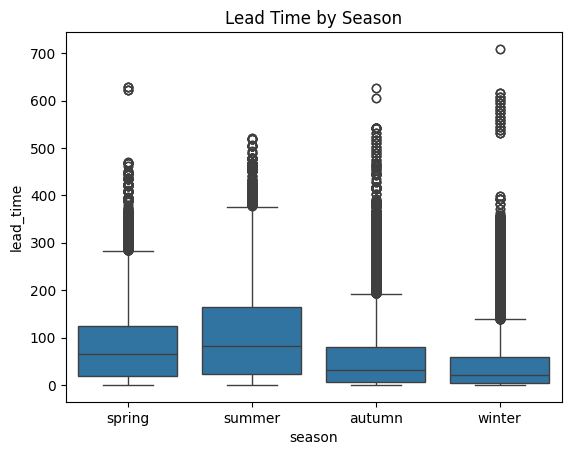

In [ ]:
sns.boxplot(data=df_main, x='season', y='lead_time')
plt.title('Lead Time by Season')
plt.show()

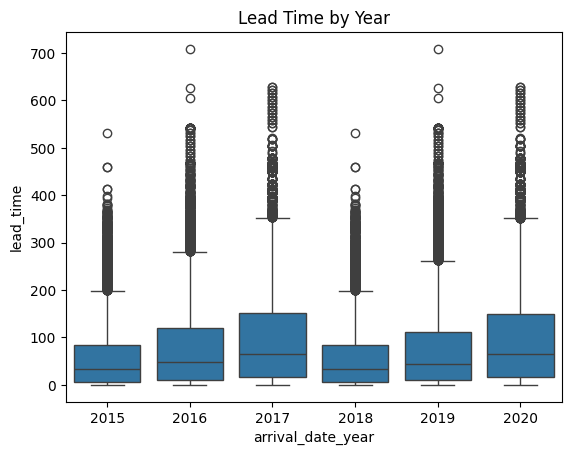

In [71]:
sns.boxplot(data=df_main, x='arrival_date_year', y='lead_time')
plt.title('Lead Time by Year')
plt.show()

## Market Segment vs Cancellation Rate

In [72]:
df_segment_cancellations = df_main.groupby("market_segment").size().reset_index().rename(columns = {0 : "bookings"})

df_segment_cancellations2 = df_main[["market_segment", "is_canceled"]].groupby("market_segment")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_segment_cancellations = df_segment_cancellations.merge(df_segment_cancellations2, on = "market_segment")

df_segment_cancellations["cancellation_rate"] = df_segment_cancellations["cancellations"] / df_segment_cancellations["bookings"]
df_segment_cancellations_basic = df_segment_cancellations[["market_segment", "cancellation_rate", "bookings", "cancellations"]].sort_values(by = "cancellation_rate", ascending = False)
df_segment_cancellations_basic

,market_segment,cancellation_rate,bookings,cancellations
7,Undefined,1.00,6,6
1,Complementary,0.60,306,184
6,Online TA,0.35,107551,37429
4,Groups,0.28,10625,2959
0,Aviation,0.20,446,90
3,Direct,0.15,25207,3762
5,Offline TA/TO,0.15,30159,4474
2,Corporate,0.12,9104,1127


At a glance, there are observations on relative cancellation rates across market segments that do make sense against prior known business logic:
- Complementary bookings involve less stake from the customer, freeing them to act in their own private interests
- Direct bookings tend to be demonstrative of greater intent, thus less likely cancellation
- Likewise when comaring offline vs online - online vendors make cancellation relatively easy; the notes from web sources at beginning of this section reflect that too
- Corporates too are more confident / cautious in their bookings, therefore cancel less ofte

Still, there remains the possibility that these market segments appear riskier / less risky for cancellation not because of native traits,<br>
but because they are over/underepresented in time periods which have naturally higher rates.<br>
A simple test is to just control for time period and compare cancellation rate across segments

In [94]:
pd.set_option('display.max_rows', 200) 
df_segment_cancellations = df_main.groupby(["arrival_date_year", "season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})

df_segment_cancellations2 = df_main[["arrival_date_year", "season", "market_segment", "is_canceled"]].groupby(["arrival_date_year", "season", "market_segment"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_segment_cancellations = df_segment_cancellations.merge(df_segment_cancellations2, on = ["arrival_date_year", "season", "market_segment"])

df_segment_cancellations["cancellation_rate"] = df_segment_cancellations["cancellations"] / df_segment_cancellations["bookings"]
df_segment_cancellations = df_segment_cancellations[["arrival_date_year", "season", "market_segment", "cancellation_rate", "bookings", "cancellations"]]
df_segment_cancellations[df_segment_cancellations["bookings"] > 0].sort_values(by = ["arrival_date_year", "season", "cancellation_rate", "market_segment"])


C:\Users\danie\AppData\Local\Temp\ipykernel_3460\2546373651.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_segment_cancellations = df_main.groupby(["arrival_date_year", "season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_3460\2546373651.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_segment_cancellations2 = df_main[["arrival_date_year", "season", "market_segment", "is_canceled"]].groupby(["arrival_date_year", "season", "market_segment"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellatio

,arrival_date_year,season,market_segment,cancellation_rate,bookings,cancellations
11,2015,summer,Direct,0.14,1091,155
13,2015,summer,Offline TA/TO,0.17,1351,233
10,2015,summer,Corporate,0.24,184,45
14,2015,summer,Online TA,0.29,2987,875
12,2015,summer,Groups,0.39,547,214
9,2015,summer,Complementary,0.67,3,2
15,2015,summer,Undefined,1.00,2,2
18,2015,autumn,Corporate,0.11,626,67
21,2015,autumn,Offline TA/TO,0.13,1467,191
19,2015,autumn,Direct,0.15,830,121


Would be ideal to do chi-square test to confirm with statistical rigour,<br>
but can at least say that based on consistent directioanality that relative cancellation risks are:<br>
"high": [Online TA, Groups, Complementary]; "low": [Offline, Direct, Corporate]

In [95]:
df_main.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()


C:\Users\danie\AppData\Local\Temp\ipykernel_3460\3657249317.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_main.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()


season,spring,summer,autumn,winter
market_segment,,,,
Aviation,0.21,0.24,0.18,0.11
Complementary,0.76,0.65,0.57,0.50
Corporate,0.12,0.21,0.11,0.08
Direct,0.15,0.17,0.15,0.11
Groups,0.28,0.36,0.23,0.27
Offline TA/TO,0.16,0.17,0.13,0.11
Online TA,0.36,0.37,0.30,0.33
Undefined,NaN,1.00,NaN,NaN


Controlling for market segment, there is again gentle evidence of a seasonal effect whereby cancellations are lower in Summer,<br>
especially removing the 'Complementary' segment, which is very small and therefore unreliable.<br><br>

There is also slight evidence here to support the idea that Spring has a higher inherent cancellation rate than Autumn,<br>
which, is a reminder, was relevant to distinguishing whether cancellation rates were lower in 2015/2018 due to year or seasonal factors.<br><br>

All told though, these are just casual inferences based on directionality, and again a statistical test would be far more ideal.<br>
This is just to suggest / motivate doing such a [set of] test(s), rather than a conclusive declaration.

In [100]:
df_main.groupby(['market_segment', 'arrival_date_year'])['is_canceled'].mean().unstack()

arrival_date_year,2015,2016,2017,2018,2019,2020
market_segment,,,,,,
Aviation,NaN,0.20,0.20,NaN,0.20,0.20
Complementary,0.61,0.54,0.72,0.61,0.56,0.72
Corporate,0.14,0.11,0.14,0.14,0.12,0.14
Direct,0.14,0.15,0.15,0.14,0.15,0.15
Groups,0.30,0.26,0.29,0.30,0.28,0.26
Offline TA/TO,0.15,0.14,0.18,0.15,0.14,0.15
Online TA,0.26,0.34,0.40,0.26,0.33,0.38
Undefined,1.00,NaN,NaN,1.00,1.00,NaN


We might say that the cancellation rate pattern observed yearly is driven by the Online TA segment,<br>
which is both the majority segment by size, and is the only one obviously following the above-mentioned yearly cancellation rate pattern.

In [97]:
# df_main.groupby(['market_segment', "arrival_date_year", "season"])['is_canceled'].mean().unstack()


In [ ]:
df_segments_by_yyyy = df_main.groupby(["arrival_date_year", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
df_segments_by_yyyy["year_bookings"] = df_segments_by_yyyy.groupby("arrival_date_year")["bookings"].transform("sum")
df_segments_by_yyyy["segment_pc"] = df_segments_by_yyyy["bookings"] / df_segments_by_yyyy["year_bookings"]
df_segments_by_yyyy = df_segments_by_yyyy.merge(df_yyyy_cancellations[["arrival_date_year", "cancellation_rate"]], on = "arrival_date_year")

df_segments_by_yyyy_pvt = df_segments_by_yyyy[["arrival_date_year", "market_segment", "segment_pc", "cancellation_rate"]]
df_segments_by_yyyy_pvt = df_segments_by_yyyy.pivot(index = ["arrival_date_year", "cancellation_rate"], columns = "market_segment", values = "segment_pc")
df_segments_by_yyyy_pvt

,market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
arrival_date_year,cancellation_rate,,,,,,,,
2015,0.21,NaN,0.00,0.06,0.16,0.10,0.24,0.44,0.00
2016,0.27,0.00,0.00,0.05,0.13,0.05,0.17,0.60,NaN
2017,0.32,0.00,0.00,0.04,0.14,0.05,0.12,0.65,NaN
2018,0.21,NaN,0.00,0.06,0.16,0.10,0.24,0.44,0.00
2019,0.26,0.00,0.00,0.05,0.13,0.06,0.18,0.57,0.00
2020,0.31,0.00,0.00,0.04,0.14,0.05,0.12,0.65,NaN


Indeed, in terms of proportional representation (size) per year,<br>
Online TA segment does fluctuate in accordance with yearly cancellation rate patterns,<br>
so we can say that both in terms of within-segment cancellation rate per year and by within-year proportional segment representation,<br>
Online TA is driving the cancellation rate fluctuations by year.<br><br>

Note that segment 'Groups' did not show in previous cell a clear pattern of increasing in cancellation likelihood per year,<br>
and in this cell, even reduces in size, so overall contributed negatively to the pattern observed, emphasising the importance of Online TA as a driver.

In [101]:
# (1) Probably best to categorise high/med/low having controlled for time-effects,
# e.g. using results from df_segment_cancellations[df_segment_cancellations["bookings"] > 0].sort_values(by = ["arrival_date_year", "season", "cancellation_rate", "market_segment"])

# (2) New cells inserted above already ascertain Online TA as the driver, and e.g. 'Groups' as distinctly not a driver (it contributed negatively to the patterns observed).
# So, to group them together at all would be a step back in terms of granularity, and would even just make for even more vague results, as the power of Online TA would be dampened

#############################################

# # Categorise the segments based on overall cancellation rate, to generate a simpler table as opposed to above, which is rather overwhelming in information

# yyyy_canc_rates = df_yyyy_cancellations["cancellation_rate"].values.tolist()

# max_yyyy_canc_rate = max(yyyy_canc_rates)
# min_yyyy_canc_rate = min(yyyy_canc_rates)

# # df_segment_rates = df_segment_cancellations_basic[["market_segment", "cancellation_rate"]]

# segment_rates = pd.Series({
#     "Undefined" : 1.00,
#     "Complementary" : 0.60,
#     "Online TA" : 0.35,
#     "Groups" : 0.28,
#     "Aviation" : 0.20,
#     "Direct" : 0.20,
#     "Offline TA/TO" : 0.15,
#     "Corporate" : 0.12
# })

# def categorise_rate(rate):
#     if rate > max_yyyy_canc_rate:
#         return "High"
#     elif rate < min_yyyy_canc_rate:
#         return "Low"
#     else:
#         return "Medium"
    
# # Category definitions could probably do with some revision / make sure this is acceptably scientific and understandable for stakeholders
# # Consider making reference to the global avg of 26% (found above)
    
# df_segment_categories = segment_rates.apply(categorise_rate).reset_index().rename(columns = {"index" : "market_segment", 0 : "cancellation_rate_category"}) # reset index to convert to df
# print(df_segment_categories)

In [102]:
# df_segment_cats_by_yyyy = df_segments_by_yyyy.merge(df_segment_categories, on = "market_segment")
# df_segment_cats_by_yyyy["cat_bookings"] =  df_segment_cats_by_yyyy.groupby(["arrival_date_year", "cancellation_rate_category"])["bookings"].transform("sum")
# df_segment_cats_by_yyyy = df_segment_cats_by_yyyy[["arrival_date_year", "cancellation_rate", "cancellation_rate_category", "year_bookings", "cat_bookings"]].drop_duplicates()
# df_segment_cats_by_yyyy["cat_pc"] = df_segment_cats_by_yyyy["cat_bookings"] / df_segment_cats_by_yyyy["year_bookings"]
# df_segment_cats_by_yyyy_pvt = df_segment_cats_by_yyyy.pivot(index = ["arrival_date_year", "cancellation_rate"], columns = "cancellation_rate_category", values = "cat_pc")
# df_segment_cats_by_yyyy_pvt # reorder high medium low

<!-- df_segment_cats_by_yyyy_pvt shows us that the differences in cancellation rate across years was driven by the relative changes in composition of market segment types, especially of high and low propensity ones.<br>

df_segments_by_yyyy_pvt shows us that most notably, Online TA segment drove the proportion of the high-propensity category, and Offline TA the low. -->

In [103]:
# df_segments_by_yyyy_szn = df_main.groupby(["arrival_date_year", "season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
# df_segments_by_yyyy_szn["year_bookings"] = df_segments_by_yyyy_szn.groupby(["arrival_date_year", "season"])["bookings"].transform("sum")
# df_segments_by_yyyy_szn["segment_pc"] = df_segments_by_yyyy_szn["bookings"] / df_segments_by_yyyy_szn["year_bookings"]
# df_segments_by_yyyy_szn = df_segments_by_yyyy_szn.merge(df_seasonal_cancellations[["arrival_date_year", "season", "cancellation_rate"]], on = ["arrival_date_year",  "season"])

# df_segments_by_yyyy_szn_pvt = df_segments_by_yyyy_szn[["arrival_date_year", "season", "market_segment", "segment_pc", "cancellation_rate"]]
# df_segments_by_yyyy_szn_pvt = df_segments_by_yyyy_szn.pivot(index = ["arrival_date_year", "season", "cancellation_rate"], columns = "market_segment", values = "segment_pc")
# df_segments_by_yyyy_szn_pvt

In [105]:
# df_segment_cats_by_yyyy_szn = df_segments_by_yyyy_szn.merge(df_segment_categories, on = "market_segment")
# df_segment_cats_by_yyyy_szn["cat_bookings"] =  df_segment_cats_by_yyyy_szn.groupby(["arrival_date_year", "season", "cancellation_rate_category"])["bookings"].transform("sum")
# df_segment_cats_by_yyyy_szn = df_segment_cats_by_yyyy_szn[["arrival_date_year", "season", "cancellation_rate", "cancellation_rate_category", "year_bookings", "cat_bookings"]].drop_duplicates()
# df_segment_cats_by_yyyy_szn["cat_pc"] = df_segment_cats_by_yyyy_szn["cat_bookings"] / df_segment_cats_by_yyyy_szn["year_bookings"]
# df_segment_cats_by_yyyy_szn_pvt = df_segment_cats_by_yyyy_szn.pivot(index = ["arrival_date_year", "season", "cancellation_rate"], columns = "cancellation_rate_category", values = "cat_pc")
# df_segment_cats_by_yyyy_szn_pvt # reorder high medium low

In [106]:
# df_segments_by_szn = df_main.groupby(["season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
# df_segments_by_szn["szn_bookings"] = df_segments_by_szn.groupby("season")["bookings"].transform("sum")
# df_segments_by_szn["segment_pc"] = df_segments_by_szn["bookings"] / df_segments_by_szn["szn_bookings"]
# df_segments_by_szn = df_segments_by_szn.merge(df_seasonal_cancellations_basic[["season", "cancellation_rate"]], on = "season")

# df_segments_by_szn_pvt = df_segments_by_szn[["season", "market_segment", "segment_pc", "cancellation_rate"]]
# df_segments_by_szn_pvt = df_segments_by_szn.pivot(index = ["season", "cancellation_rate"], columns = "market_segment", values = "segment_pc")
# df_segments_by_szn_pvt

In [107]:
# df_segment_cats_by_szn = df_segments_by_szn.merge(df_segment_categories, on = "market_segment")
# df_segment_cats_by_szn["cat_bookings"] = df_segment_cats_by_szn.groupby(["season", "cancellation_rate_category"])["bookings"].transform("sum")
# df_segment_cats_by_szn = df_segment_cats_by_szn[["season", "cancellation_rate", "cancellation_rate_category", "szn_bookings", "cat_bookings"]].drop_duplicates()
# df_segment_cats_by_szn["cat_pc"] = df_segment_cats_by_szn["cat_bookings"] / df_segment_cats_by_szn["szn_bookings"]
# df_segment_cats_by_szn_pvt = df_segment_cats_by_szn.pivot(index = ["season", "cancellation_rate"], columns = "cancellation_rate_category", values = "cat_pc")
# df_segment_cats_by_szn_pvt # reorder high medium low

<!-- By season, again generally there is a driving force to be found in the composition of segments as categorised by their propensity to cancel.<br>
For the high-propensity category, Online TA is again the most signficiant single segment.<br>
For the low-propensity category, it is more about the combined 'effort' of Offline TA, Direct, and Corporate. -->

## Market Segment vs Lead Time

In [79]:
# Market segments: avg lead times and net cancellation rates:
df_segment_lead_time = df_main.groupby(["market_segment"])["lead_time"].mean().reset_index()#.rename(columns = {0 : "bookings"})

df_segment_lead_time = df_segment_lead_time.merge(df_segment_cancellations_basic, on = "market_segment").sort_values(by = "cancellation_rate", ascending = False)
df_segment_lead_time

,market_segment,lead_time,cancellation_rate,bookings,cancellations
7,Undefined,1.50,1.00,6,6
1,Complementary,25.58,0.60,306,184
6,Online TA,78.31,0.35,107551,37429
4,Groups,145.05,0.28,10625,2959
0,Aviation,4.35,0.20,446,90
3,Direct,47.91,0.15,25207,3762
5,Offline TA/TO,104.33,0.15,30159,4474
2,Corporate,16.20,0.12,9104,1127


Would appear that the consistent positive relationship posited between lead time and cancellation rate is broken.<br>
Thus, the story evolves to consider market segments to have inherent qualities and/or qualities beyond lead time that impact their propensity to cancel.<br>
To reinstate confidence in lead time as a factor, can do so by holding market segment constant, as below.


In [108]:
# Probably best to add on median statistic, and also try categorising lead times and seeing split across these categories.
# To be completed.
df_lead_time_segment = df_segment_lead_time = df_main.groupby(["market_segment", "is_canceled"])["lead_time"].mean().reset_index()#.rename(columns = {0 : "bookings"})
# df_lead_time_segment = df_lead_time_segment.merge(df_segment_cancellations_basic, on = "market_segment")
df_lead_time_segment

,market_segment,is_canceled,lead_time
0,Aviation,0,4.17
1,Aviation,1,5.04
2,Complementary,0,37.06
3,Complementary,1,17.97
4,Corporate,0,14.19
5,Corporate,1,30.41
6,Direct,0,44.14
7,Direct,1,69.46
8,Groups,0,130.94
9,Groups,1,181.62


Above, it is seen that the average lead time per market segment for cancellations is indeed greater than that for fulfilled bookings,<br>
except for the 'Complementary' segment.<br>
A potential explanation for the Complementary segment acting in reverse to the others is ...<br>
... Add % diff or other such comparison per segment ...

Seeing as Online TA is known to have a higher cancellation rate tahn Offline TA (for example), yet clearly has lower lead times whethre cancelled or not,<br>
lead time is definitely not the sole factor driving cancellation rate.<br>
In other other words, based on evidence thus far, market segment does have inherent properties influencing cancellation rates - or at least properties besides lead time.

- https://www.siteminder.com/r/hotel-distribution-concepts-best-practice/
- A hotel distribution channel can be any method or platform by which your hotel sells its rooms.

- vs market_segment = customer profiling

- E.g. 'direct' market_segment refers to customer booking directly for themselves, as opposed to for a group tour or corporate,<br>whilst 'direct' distribution_channel refers to the rooms having been booked via the hotel website / walk-in / similar direct action

- For whatever reason, distribution_channel data here doesn't distinguish offline/online, but can still try seeing any patterns across the existing channels given